In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import pickle

In [2]:
df = pd.read_csv('../Dataset/FunctionalDecomposition.csv')

In [3]:
df.sample(5)

,Code,Class,NMO,DIT,Smell
259,class OfficeChairs{\n void place() {\n ...,OfficeChairs,0,1,0
415,class Software {\r\n void install() {\r\n ...,GameSoftware,1,2,1
452,class BeverageContainer {\r\n void fill() {...,InsulatedThermosBottle,1,4,1
268,class RedRoses{\n void bloom() {\n S...,RedRoses,0,1,0
584,class Software {\n void install() {\n ...,OperatingSystem,1,2,1


In [4]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['Smell'] = encoder.fit_transform(df['Smell'])

In [6]:
df.head()

,Code,Class,NMO,DIT,Smell
0,public class Vehicle {\n public void start(...,Vehicle,0,1,0
1,public class Vehicle {\n public void start(...,Car,2,2,1
2,public class Vehicle {\r\n public void star...,Bicycle,1,3,1
3,class Animal {\r\n void sound() {\r\n ...,Animal,0,1,0
4,class Animal {\r\n void sound() {\r\n ...,Dog,1,2,1


In [7]:
df['Smell'].value_counts()

Smell
1    353
0    234
Name: count, dtype: int64

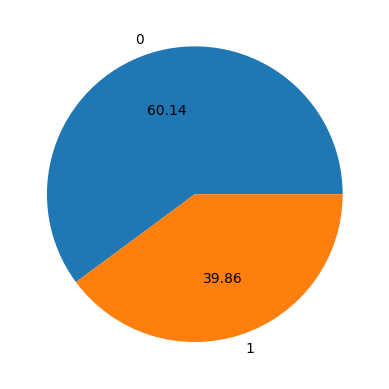

In [5]:
plt.pie(df['Smell'].value_counts(), labels=['0','1'],autopct="%0.2f")
plt.show()

In [8]:
!pip install javalang

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import javalang

In [10]:
def parse_code_to_ast(code):
    try:
        return javalang.parse.parse(code)
    except (javalang.parser.JavaSyntaxError, javalang.tokenizer.LexerError):
        return None

In [11]:
df['AST'] = df['Code'].apply(parse_code_to_ast)

In [12]:
def get_class_tree(ast):
    class_tree = {}
    for path, node in ast.filter(javalang.tree.ClassDeclaration):
        class_name = node.name
        parent_name = node.extends.name if node.extends else None
        class_tree[class_name] = parent_name
    return class_tree

In [13]:
def get_methods(ast, class_name):
    methods = set()
    for path, node in ast.filter(javalang.tree.MethodDeclaration):
        if isinstance(path[-2], javalang.tree.ClassDeclaration) and path[-2].name == class_name:
            methods.add(node.name)
    return methods

In [14]:
def get_all_parent_methods(class_tree, class_name, ast):
    parent_methods = set()
    while class_name in class_tree and class_tree[class_name] is not None:
        class_name = class_tree[class_name]
        parent_methods.update(get_methods(ast, class_name))    
    return parent_methods

In [15]:
def calculate_dit(class_tree, class_name):
    depth = 0
    while class_name in class_tree and class_tree[class_name] is not None:
        class_name = class_tree[class_name]
        depth += 1
    return depth

In [16]:
def calculate_nmo(class_methods, parent_methods):
    return len(class_methods.intersection(parent_methods))

In [17]:
for index, row in df.iterrows():
    ast = row['AST']
    if ast is None:
        continue  
    
    class_tree = get_class_tree(ast)
    for cls in class_tree.keys():
        class_methods = get_methods(ast, cls)
        parent_methods = get_all_parent_methods(class_tree, cls, ast)
        nmo = calculate_nmo(class_methods, parent_methods)
        dit = calculate_dit(class_tree, cls) + 1

        print(f"Class: {cls}, NMO: {nmo}, DIT: {dit}")

Class: Vehicle, NMO: 0, DIT: 1
Class: Car, NMO: 2, DIT: 2
Class: Bicycle, NMO: 1, DIT: 3
Class: Vehicle, NMO: 0, DIT: 1
Class: Car, NMO: 2, DIT: 2
Class: Bicycle, NMO: 1, DIT: 3
Class: Vehicle, NMO: 0, DIT: 1
Class: Car, NMO: 2, DIT: 2
Class: Bicycle, NMO: 1, DIT: 3
Class: Animal, NMO: 0, DIT: 1
Class: Dog, NMO: 1, DIT: 2
Class: Bulldog, NMO: 1, DIT: 3
Class: Animal, NMO: 0, DIT: 1
Class: Dog, NMO: 1, DIT: 2
Class: Bulldog, NMO: 1, DIT: 3
Class: Animal, NMO: 0, DIT: 1
Class: Dog, NMO: 1, DIT: 2
Class: Bulldog, NMO: 1, DIT: 3
Class: Animal, NMO: 0, DIT: 1
Class: Dog, NMO: 1, DIT: 2
Class: Bulldog, NMO: 1, DIT: 2
Class: Vehicle, NMO: 0, DIT: 1
Class: Car, NMO: 1, DIT: 2
Class: Vehicle, NMO: 0, DIT: 1
Class: Car, NMO: 1, DIT: 2
Class: Vehicles, NMO: 0, DIT: 1
Class: Car, NMO: 1, DIT: 2
Class: ElectricCar, NMO: 1, DIT: 3
Class: Vehicles, NMO: 0, DIT: 1
Class: Car, NMO: 1, DIT: 2
Class: ElectricCar, NMO: 1, DIT: 3
Class: Vehicles, NMO: 0, DIT: 1
Class: Car, NMO: 1, DIT: 2
Class: ElectricCar

In [18]:
X = df[["NMO", "DIT"]]
y = df['Smell'].values

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [21]:
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
y_pred1 = mnb.predict(X_test)
print(y_pred1)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

[1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 0
 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1
 0 0 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1
 1 0 0 0 1 0 1]
0.9915254237288136
[[49  0]
 [ 1 68]]
1.0


In [22]:
with open('../Pkl File/functional_decomposition.pkl', 'wb') as model_file:
    pickle.dump(mnb, model_file)